In [1]:
import numpy as np
import matplotlib.pyplot as plt

import supervisely_lib as sly

from tqdm import tqdm
from collections import defaultdict, Counter

%matplotlib inline

In [2]:
address = 'http://192.168.1.69:5555'
token = 'YGPDnuBkhFmcQ7VNzSEjhgavjg4eFR4Eq1C3jIY4HgV3SQq2JgkXCNtgZy1Fu2ftd4IKui8DsjrdtXjB853cMtBevpSJqFDYiaG1A5qphlH6fFiYYmcVZ5fMR8dDrt5l'
team_name = 'dima'
workspace_name = 'work'

src_project_name = 'lemons_annotated'

In [3]:
api = sly.Api(address, token)

team_id = api.team.get_info_by_name(team_name)['id']
workspace_id = api.workspace.get_info_by_name(workspace_name, team_id)['id']

src_project_id = api.project.get_info_by_name(src_project_name, workspace_id)['id']

src_meta_json = api.project.get_meta(src_project_id)
src_meta = sly.ProjectMeta.from_json(src_meta_json)

In [4]:
research_classes = ['kiwi', 'lemon']

In [5]:
def process_ann(ann, classes, res_count, res_area):
    img_size = ann.img_size
    for cls_name in classes:
        count = 0
        area = 0
        for label in ann.labels:
            if label.obj_class.name == cls_name:
                count += 1
                area += label.area / (img_size[0] * img_size[1])
        res_area[cls_name].append(area)
        res_count[cls_name].append(count)

In [6]:
res_count = defaultdict(list)
res_area = defaultdict(list)

for dataset_info in api.dataset.get_list(src_project_id):
    src_dataset_id = dataset_info['id']
    src_dataset_name = dataset_info['name']

    print('Project/Dataset: {}/{}'.format(src_project_name, src_dataset_name))
    
    for image_info in tqdm(api.image.get_list(src_dataset_id)):
        src_image_ext = image_info['meta']['mime'].split('/')[1]

        ann_json = api.annotation.download(src_dataset_id, image_info['id'])
        ann = sly.Annotation.from_json(ann_json, src_meta)
        process_ann(ann, research_classes, res_count, res_area)

 67%|██████▋   | 4/6 [00:00<00:00, 32.09it/s]

Project/Dataset: lemons_annotated/ds1


100%|██████████| 6/6 [00:00<00:00, 33.32it/s]


Resulting distributions for class - 'kiwi'.



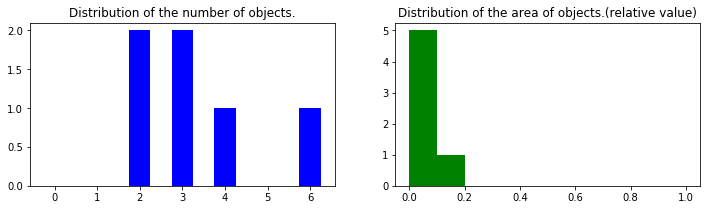


Resulting distributions for class - 'lemon'.



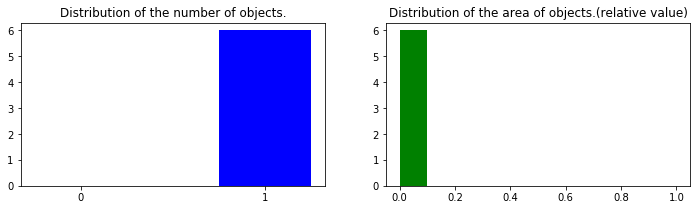

In [7]:
for cls_name in research_classes:
    print('Resulting distributions for class - {!r}.'.format(cls_name))
    print()
    fig, ax = plt.subplots(1, 2, figsize=(12, 3))
    counter = Counter(res_count[cls_name])
    indexes = np.arange(max(res_count[cls_name]) + 1)
    values = [counter[x] for x in indexes]
    ax[0].set_title('Distribution of the number of objects.')
    ax[0].set_xticks(indexes)
    ax[0].bar(indexes, values, 0.5, color='b')
    
    ax[1].set_title('Distribution of the area of objects.(relative value)')
    ax[1].hist(res_area[cls_name], range=(0, 1), color='g')
    plt.show()
    print()